# Additional Analysis: PCA
This notebook aims to answer the question if all the 1900 features learned by eUniRep are really necessary, or if we can reduce the dimensionality and get better results. We also visualize the data using PCA and t-SNE.

In [4]:
#@title Install softwares
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import urllib3
import gzip


try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

JAX_UNIREP_REPO='https://github.com/ElArkk/jax-unirep.git'
DOWNLOAD_PFAM_SCRIPT='https://raw.githubusercontent.com/xqding/PEVAE_Paper/master/pfam_msa/script/download_MSA.py'
ENTREZ_URL='ftp://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect//install-edirect.sh'

ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_BLAST=f"{RES_DIR}/MSA/blast"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
pathes=['/usr/local/cuda-11.4/bin']
libpathes=['/usr/local/cuda-11.4/lib64']

CONDA_PATH='/opt/anaconda3'

# if not already installed
total = 3
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [ROOT_DIR,
              TMP_DIR,FLAG_DIR,WEIGHTS_DIR,SCRIPTS_DIR,
              JOBS_DIR,
              RES_DIR,RES_DIR_MSA,RES_DIR_BLAST,RES_DIR_FITNESS,RES_DIR_SEQ_OUT,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(1)

  for path in pathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['PATH']:
      os.environ['PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['PATH']}"
  '''
  for path in libpathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['LD_LIBRARY_PATH']:
      os.environ['LD_LIBRARY_PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['LD_LIBRARY_PATH'] }"
  '''
  pbar.update(1)


  # weights
  '''for p in ["tqdm","jax-unirep","biopython","awscli","optuna","seaborn","python-Levenshtein","feather-format"]:
    os.system(f'pip install {p}')'''
  pbar.update(1)
  

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

In [5]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather



In [6]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    # Yinying edited here bcs pfam provides stockholm formated file. 
    # PFam use stockholm while InterPro use fasta
    
    fasta_seqs = SeqIO.parse(open( name ), name.suffix.replace(".",''))
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    return data


# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(fitness_csv,seq_col,fit_col): 
  df=pd.read_csv(pathlib.Path(fitness_csv),usecols=[seq_col,fit_col])
  data = []
  for seq, fitness in zip(df.loc[:, seq_col], df.loc[:, fit_col]):
        data.append([str(seq).strip(), fitness])
  return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [8]:
#@title load the reps you want into dataframes
PROJECT_NAME='evotuning_P450_from'

gdrive_path=f'{RES_DIR_PICKLE}/'
DIR_PATH = f'{RES_DIR_FEATURE}/{PROJECT_NAME}'
#os.system(f'mkdir -p {pathlib.Path(DIR_PATH).resolve()}')

PARAMS = [ '_global/iter_0','_randinit/iter_0',None, 'one_hot',]




FEATHER_PATH = gdrive_path 

unirep_df = read_reps(FEATHER_PATH + 'unirep')
eunirep_df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')
rand_eunirep_df=read_reps(FEATHER_PATH + 'evotuning_P450_from-_randinit_iter_0')
onehot_df = read_reps(FEATHER_PATH + 'one_hot')

dfs = [unirep_df, eunirep_df, onehot_df,rand_eunirep_df]
df_names = ['unirep', 'eunirep', 'one hot','rand_eunirep']

#### 3-Component PCA visualized
First lets visualize what the 3 component PCA's look like

unirep explained variation per top 3 PC: [0.3715242  0.2359483  0.10123207]
eunirep explained variation per top 3 PC: [0.34045824 0.13092892 0.08644053]
one hot explained variation per top 3 PC: [0.31664699 0.11266437 0.10349802]
rand_eunirep explained variation per top 3 PC: [0.3535278  0.17607646 0.1331943 ]


<Figure size 432x288 with 0 Axes>

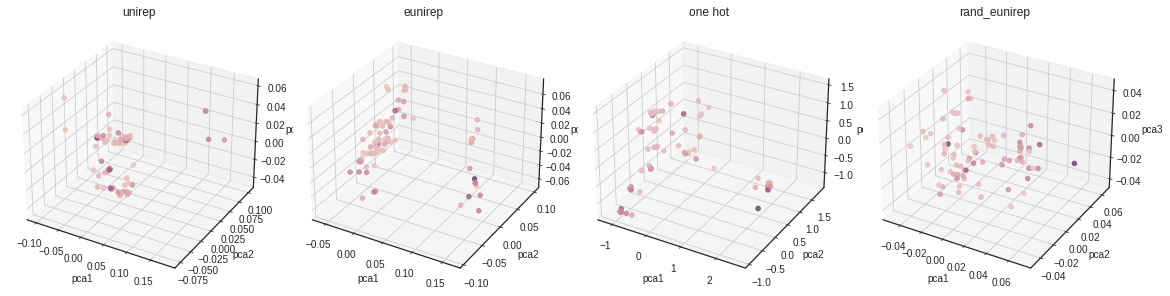

In [11]:
N_COMPS = 84

plt.clf()
fig = plt.figure(figsize=(4*len(dfs),4))
plt.style.use('seaborn-white')

for i in range(len(dfs)):
  pca = PCA(n_components=N_COMPS)
  pca_result = pca.fit_transform(dfs[i][dfs[i].columns[2:]].values)
  dfs[i]['pca1'] = pca_result[:,0]
  dfs[i]['pca2'] = pca_result[:,1] 
  dfs[i]['pca3'] = pca_result[:,2]
  print(df_names[i], 'explained variation per top 3 PC: {}'.format(pca.explained_variance_ratio_[0:3]))

  ax = fig.add_subplot(1,len(dfs),(i+1), title=df_names[i], projection="3d")
  ax.scatter(
      xs=dfs[i]["pca1"], 
      ys=dfs[i]["pca2"], 
      zs=dfs[i]["pca3"], 
      c=dfs[i]["fitness"],
      cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
      alpha=0.8
  )

  ax.set_xlabel('pca1')
  ax.set_ylabel('pca2')
  ax.set_zlabel('pca3')


plt.tight_layout()
plt.show()


#### Top model training on N-component PCAs
We're now going to try varying the N-components used and comparing peformance to the full unirep, eunirep and one-hot representations.

unirep [0.8116883116883117, 1.2066365007541477, 1.1182108626198084, 1.2232415902140672, 1.238390092879257, 1.070336391437309, 1.355421686746988, 1.228878648233487, 1.36986301369863, 1.1678832116788322, 1.109350237717908, 1.3493253373313343, 1.5797788309636651, 1.4195583596214512, 1.1730205278592374, 1.225114854517611, 1.2269938650306749, 1.1627906976744187, 1.5600624024960998, 1.2517385257301807] Mean Score: 1.242414197444671
unirep PCA comps: 10 Mean Score: 1.227138706330517
unirep PCA comps: 50 Mean Score: 1.227138706330517
unirep PCA comps: 100 Mean Score: 1.227138706330517
unirep PCA comps: 500 Mean Score: 1.227138706330517
unirep PCA comps: 1000 Mean Score: 1.227138706330517
eunirep [1.461038961038961, 1.3574660633484164, 1.597444089456869, 1.2232415902140672, 1.238390092879257, 1.3761467889908257, 1.355421686746988, 1.228878648233487, 1.36986301369863, 1.3138686131386863, 1.4263074484944533, 1.0494752623688155, 1.5797788309636651, 1.2618296529968454, 1.3196480938416422, 1.2251148

rand_eunirep PCA comps: 100 Mean Score: 1.2695539377835874
rand_eunirep PCA comps: 500 Mean Score: 1.2695539377835874
rand_eunirep PCA comps: 1000 Mean Score: 1.2695539377835874
unirep [1.1612903225806452, 1.331719128329298, 1.288659793814433, 0.9931719428926133, 1.215066828675577, 1.1443102352193262, 1.1543134872417982, 1.1350059737156513, 1.336432306798373, 1.3613861386138615, 1.0526315789473686, 1.1235955056179776, 1.037851037851038, 1.1392405063291138, 1.1466505733252867, 1.35048231511254, 1.3174404015056462, 1.10658124635993, 1.2915129151291511, 1.037463976945245] Mean Score: 1.1862403107502435
unirep PCA comps: 10 Mean Score: 1.2136635572215446
unirep PCA comps: 50 Mean Score: 1.2136635572215446
unirep PCA comps: 100 Mean Score: 1.2136635572215446
unirep PCA comps: 500 Mean Score: 1.2136635572215446
unirep PCA comps: 1000 Mean Score: 1.2136635572215446
eunirep [1.2258064516129032, 1.4527845036319613, 1.288659793814433, 1.2414649286157666, 1.2758201701093559, 1.3350286077558804, 1

rand_eunirep PCA comps: 10 Mean Score: 1.1657235101451602
rand_eunirep PCA comps: 50 Mean Score: 1.1657235101451602
rand_eunirep PCA comps: 100 Mean Score: 1.1657235101451602
rand_eunirep PCA comps: 500 Mean Score: 1.1657235101451602
rand_eunirep PCA comps: 1000 Mean Score: 1.1657235101451602
unirep [1.0290986515259049, 1.0286554004408524, 1.1035653650254669, 1.100762066045724, 1.096319498825372, 1.058873358746294, 1.0980689132904202, 1.026615969581749, 1.0984987184181618, 1.1038430089942763, 0.9874667679453096, 1.0297482837528604, 0.9993108201240524, 1.0582010582010581, 1.0276399716513112, 1.0966693744922826, 1.1010617381046008, 1.1071428571428572, 1.1106703689012296, 1.093693036820999] Mean Score: 1.0677952614015391
unirep PCA comps: 10 Mean Score: 1.0480159851484403
unirep PCA comps: 50 Mean Score: 1.0480159851484403
unirep PCA comps: 100 Mean Score: 1.0480159851484403
unirep PCA comps: 500 Mean Score: 1.0480159851484403
unirep PCA comps: 1000 Mean Score: 1.0480159851484403
eunirep 

<Figure size 432x288 with 0 Axes>

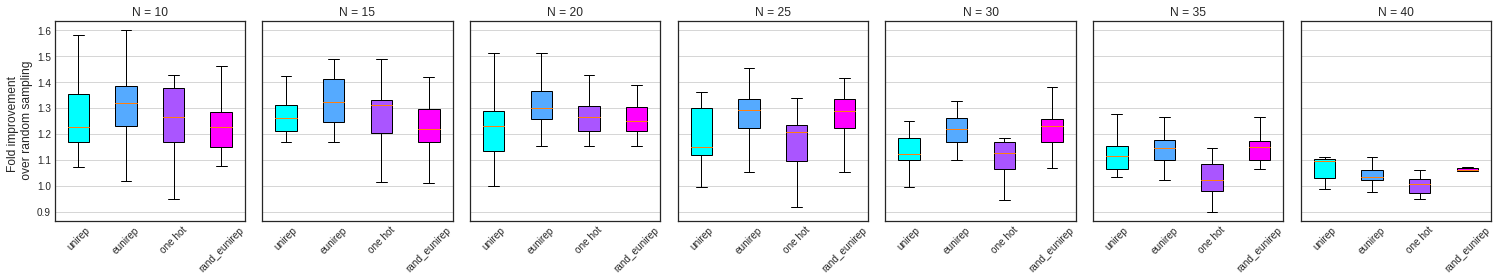

In [12]:
# regularization hyperparameters
#ALPHAS = [0.01, 0.01, 0.1]
ALPHAS = [ 0.0015, 0.02,1,0.01]

# number of batches to test
N_BATCH = 20

# number of sequences per training batch
#TRAIN_BATCH_SIZES = [24, 64, 96]
TRAIN_BATCH_SIZES = [10,15,20,25,30,35,40] 

# number of random trials to perform for baseline
#N_RAND_BATCHES = 20
N_RAND_BATCHES = 100

# wild-type fitness
#WT_FIT = 1
WT_FIT = 0.0121563

# components for PCA
N_COMPS=[10,50,100,500,1000]

batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:1901]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:1901]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    params_level.append(scores_level)
    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))

    # ADD PCAs:
    for n_comp in N_COMPS:
      pca_score_level = []
      for i in range(N_BATCH):
        # change random seed for each batch
        np.random.seed(42*(i+2))
        rndperm = np.random.permutation(df.shape[0])

        # data setup
        X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[1901:(1901+n_comp)]]
        Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

        X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[1901:(1901+n_comp)]]
        Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

        # ridge regression model setup
        kfold = KFold(n_splits=10, shuffle=True)

        model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

        # fit the model
        model.fit(X, Y)

        # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
        Y_preds = model.predict(X_holdout)

        usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

        # Note: wild-type fitness = WT_FIT (thats the scoring metric)
        usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

        # randomly shuffle holdout set RAND_BATCHES time
        # and take average of top TRAIN_BATCH_SIZE fitness
        avg_rand_count = 0
        for k in range(N_RAND_BATCHES):
          np.random.seed(42*(i+2) + (1+k))
          rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
          avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
        avg_rand_count /= N_RAND_BATCHES

        # final score ratio:
        pca_score_level.append(usorted_count/avg_rand_count)

      print(df_names[j], 'PCA comps:', n_comp, "Mean Score:", np.mean(pca_score_level))


  batch_level.append(params_level)

plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


Our results show for this particular dataset that for all unirep and eunirep trials PCA dimensionality reduction reduces top model performance, whereas the only single instance of PCA (almost negigibly) improving performance is in the one-hot encodings for N=96 with all 1000 principal components used.

#### t-SNE visualizations
We can try do t-SNE visualizations on our datasets as well. 

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 769.573408
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.332230
[t-SNE] KL divergence after 1400 iterations: 0.016107


<Figure size 432x288 with 0 Axes>

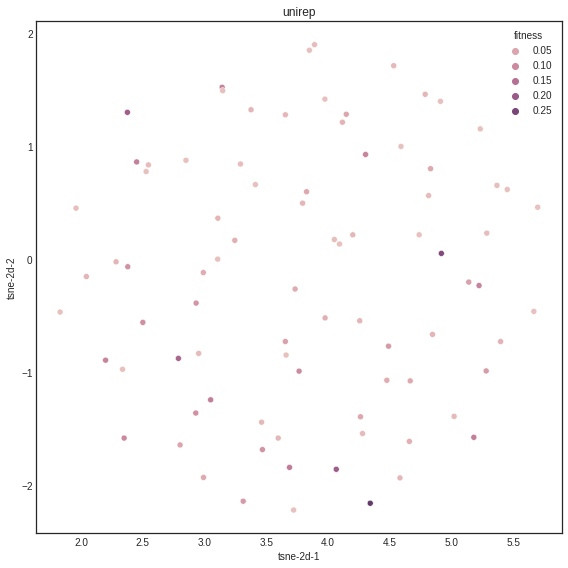

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 784.652130
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.525936
[t-SNE] KL divergence after 900 iterations: 0.015928


<Figure size 432x288 with 0 Axes>

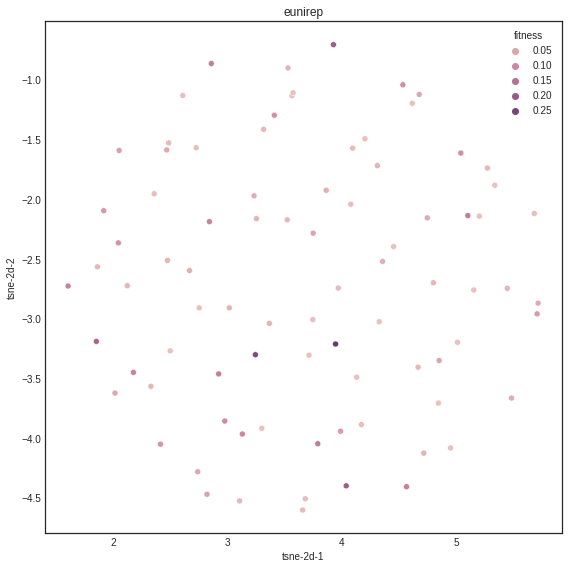

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.777233
[t-SNE] KL divergence after 450 iterations: 0.000000


<Figure size 432x288 with 0 Axes>

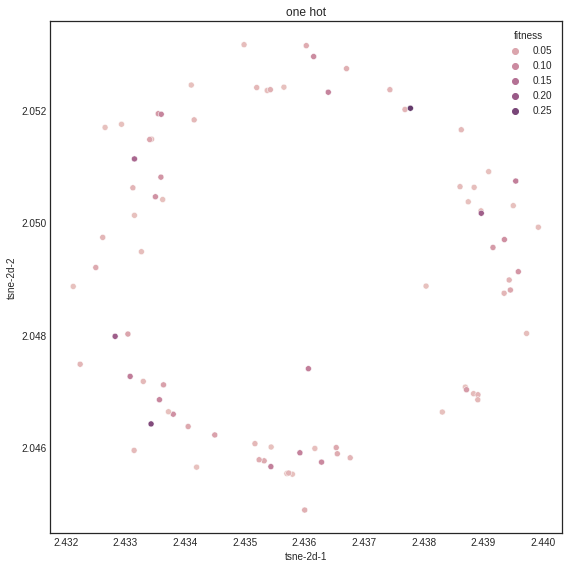

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 758.774574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.066334
[t-SNE] KL divergence after 1250 iterations: 0.015118


<Figure size 432x288 with 0 Axes>

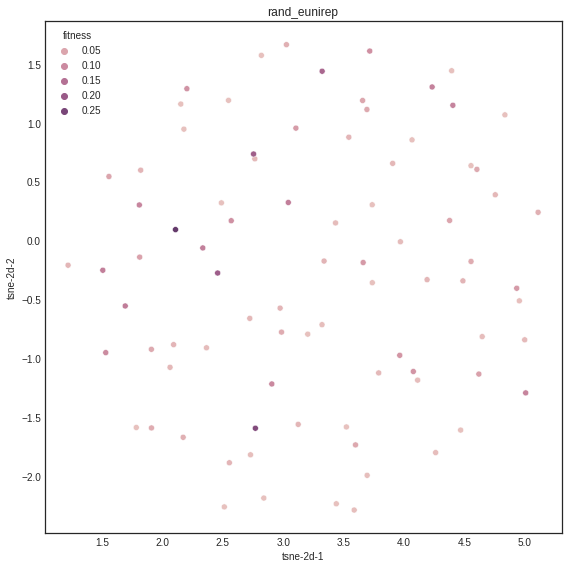

In [16]:
eunirep_df = dfs[1]


for df,df_name in zip(dfs,df_names):
    tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=9000)
    tsne_results = tsne.fit_transform(df[df.columns[1901:1921]].values)
    df['tsne-2d-1'] = tsne_results[:,0]
    df['tsne-2d-2'] = tsne_results[:,1]

    plt.clf()
    fig = plt.figure(figsize=(8,8))

    ax1 = fig.add_subplot(1,1,1, title=df_name)

    sns.scatterplot(
        x="tsne-2d-1", y="tsne-2d-2",
        hue="fitness",
        palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
        data=df,
        legend="brief",
        ax=ax1,
        #alpha=0.3
    )

    plt.tight_layout()
    plt.show()
